### 1. Import dependencies

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

Using TensorFlow backend.


In [3]:
keras.__version__

'2.2.4'

### 2. Create Keras data generators 

In [4]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    batch_size=32,
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    'data/validation',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### 3. Create the network

In [6]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

C:\Users\edwvi\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 164s 2us/step


In [7]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [8]:
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

### 4. Train the model

In [13]:
history = model.fit_generator(generator=train_generator,
                              epochs=3,steps_per_epoch=100,
                              validation_data=validation_generator, validation_steps=100)

Epoch 1/3
100/100 [==============================] - 238s 2s/step - loss: 0.2029 - acc: 0.9143 - val_loss: 0.3594 - val_acc: 0.8774
Epoch 2/3
100/100 [==============================] - 220s 2s/step - loss: 0.0694 - acc: 0.9749 - val_loss: 0.3239 - val_acc: 0.8953
Epoch 3/3
100/100 [==============================] - 220s 2s/step - loss: 0.0511 - acc: 0.9807 - val_loss: 0.1883 - val_acc: 0.9260


### 5. Save and load the model

In [16]:
# architecture and weights to HDF5
model.save('models/keras/model.h5')

# architecture to JSON, weights to HDF5
model.save_weights('models/keras/weights.h5')
with open('models/keras/architecture.json', 'w') as f:
        f.write(model.to_json())

In [17]:
# architecture and weights from HDF5
model = load_model('models/keras/model.h5')

# architecture from JSON, weights from HDF5
with open('models/keras/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('models/keras/weights.h5')

### 6. Make predictions on sample test images

In [76]:
validation_img_paths = ["data/validation/alien/11.jpg",
                        "data/validation/alien/22.jpg",
                        
                       "data/validation/fam/edw.jpg",
                        "data/validation/fam/seb.jpg",
                        "data/validation/fam/sal.jpg",
                        "data/validation/fam/est.jpg",
                        "data/validation/fam/pok0.jpg"
                       ]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [77]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224,224))))
                             for img in img_list])

In [78]:
pred_probs = model.predict(validation_batch)

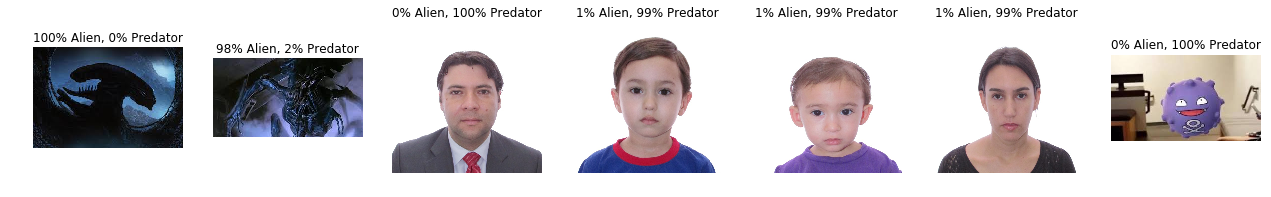

In [79]:
fig, axs = plt.subplots(1, len(img_list), figsize=(22, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)